### **High Frequency Trading Strategies Design using ML and DL**

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 13 22:40:00 2022

@author: Bradley

HFT: Machine Learning Techniques on Full Orderbook Tick Data
"""

'\nCreated on Sun Mar 13 22:40:00 2022\n\n@author: Bradley\n\nHFT: Machine Learning Techniques on Full Orderbook Tick Data\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import csv

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (8,5) #提前设置图片形状大小

%config InlineBackend.figure_format = 'svg'

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

#### **HFT Orderbook Factors**

**In this project, two typical type of factors are extracted from the orderbook: Rise Ratio & Depth Ratio.**

We start from depth ratio. 

Recall that in our lecture, a typical microstructure signal is called order book imbalance (OBI), which is defined as:

$$OBI=\frac{Q_b-Q_a}{Q_b+Q_a}$$
This classic signal can be applied to high-level orderbook. In this project, we design two advanced trading signals - **Depth ratio** and **weighted average level-3 OBI**:

$$WQ_b = \sum_{i=1}^3 w_i \times Q_{b,i}$$
$$WQ_a = \sum_{i=1}^3 w_i \times Q_{a,i}$$
$$Depth = \frac{WQ_a}{WQ_b}$$
$$OBI = \frac{WQ_b-WQ_a}{WQ_b+WQ_a}$$

In [4]:
# obtain columns respectively from orderbook
def order_book(month,day):
    data = []
    datapath = './data/order_book_3_2014' + '_' + str(1) + '_' + str(2) + '.csv'
    order = pd.read_csv(datapath,sep=',')
    bid_price_1 = np.array(order['Bid'][1::4].astype("float64"))/100 #bid1
    bid_price_2 = np.array(order['Bid'][2::4].astype("float64"))/100 #bid2
    bid_price_3 = np.array(order['Bid'][3::4].astype("float64"))/100 #bid3
    timestamp = np.array(order['Bid_Quantity'][0::4]) #每个tick data的时间
    bid_quantity_1 = np.array(order['Bid_Quantity'][1::4].astype("float64"))/100 #bidqty1
    bid_quantity_2 = np.array(order['Bid_Quantity'][2::4].astype("float64"))/100 #bidqty2
    bid_quantity_3 = np.array(order['Bid_Quantity'][3::4].astype("float64"))/100 #bidqty3
    ask_price_1 = np.array(order['Ask'][1::4].astype("float64"))/100 #ask1
    ask_price_2 = np.array(order['Ask'][2::4].astype("float64"))/100 #ask2
    ask_price_3 = np.array(order['Ask'][3::4].astype("float64"))/100 #ask3
    ask_quantity_1 = np.array(order['Ask_Quantity'][1::4].astype("float64"))/100 #askqty1
    ask_quantity_2 = np.array(order['Ask_Quantity'][2::4].astype("float64"))/100 #askqty1
    ask_quantity_3 = np.array(order['Ask_Quantity'][3::4].astype("float64"))/100 #askqty1
    
    # 填充缺失值为0
    bid_quantity_1[np.isnan(bid_quantity_1)] = 0
    bid_quantity_2[np.isnan(bid_quantity_2)] = 0
    bid_quantity_3[np.isnan(bid_quantity_3)] = 0
    ask_quantity_1[np.isnan(ask_quantity_1)] = 0
    ask_quantity_2[np.isnan(ask_quantity_2)] = 0
    ask_quantity_3[np.isnan(ask_quantity_3)] = 0
    
    return timestamp,order,bid_price_1,bid_price_2,bid_price_3,bid_quantity_1,\
            bid_quantity_2,bid_quantity_3,ask_price_1,ask_price_2,ask_price_3,ask_quantity_1,\
            ask_quantity_2,ask_quantity_3

In [5]:
# time_second是将timestamp数据格式转换为全按分钟计算
# time_second_basic是讲上面的转换结果减去一个32400
# 作用是使得上午的交易时间[0, 9000]对应09:00 ~ 11:30，下午的交易时间[14400, 25200]对应13:00 ~ 16:00，借以将上下午分开
def time_transform(timestamp_time):
    time_second_basic = []
    time_second = []
    for i in range(0,len(timestamp_time),1):
        second = float(timestamp_time[i][11])*36000 + float(timestamp_time[i][12])*3600+\
                    float(timestamp_time[i][14])*600 + float(timestamp_time[i][15])*60+\
                    float(timestamp_time[i][17])*10 + float(timestamp_time[i][18])  
        time_second_basic.append(second - 32400.0)
        time_second.append(second)
    return np.array(time_second),np.array(time_second_basic)

In [6]:
# 读取数据
month = 1
day = 2
timestamp,order,bid_price_1,bid_price_2,bid_price_3,\
bid_quantity_1,bid_quantity_2,bid_quantity_3,\
ask_price_1,ask_price_2,ask_price_3,ask_quantity_1,\
ask_quantity_2,ask_quantity_3 = order_book(month,day)
order

Bid                   Bid_Quantity       Ask  Ask_Quantity
0       TimeStamp  2014-01-02D08:45:00.296582600       NaN           NaN
1          708000                            210  682000.0         210.0
2          700500                              2  715500.0           2.0
3          699000                              2  717500.0           1.0
4       TimeStamp  2014-01-02D08:45:00.296582600       NaN           NaN
...           ...                            ...       ...           ...
186715   703000.0                           27.0  705000.0         167.0
186716  TimeStamp  2014-01-02D16:00:00.024493700       NaN           NaN
186717   703500.0                          150.0  704000.0          23.0
186718   703000.0                           27.0  704500.0          18.0
186719   702500.0                          125.0  705000.0         167.0

[186720 rows x 4 columns]

In [12]:
# 转换时间格式
time_second,time_second_basic = time_transform(timestamp)
print(time_second)
print(time_second_basic)

[31500. 31500. 31500. ... 57594. 57595. 57600.]
[ -900.  -900.  -900. ... 25194. 25195. 25200.]


In [13]:
# 自定义训练标签，0代表应该空仓，1代表多仓
# 尽管数据是的tick级别，我们在trade的时候只会以秒为单位。因此我们定义的trade label都是每秒级别的数据
# 大体意思：站在每一秒的节点，如果我发现当前的bid price要高于未来15分钟(即900s)的ask price的最小值，那我认为此时应该买入(label=1)。反之则需要卖出(label=0)。
# 意为如果当前bid price高于未来15分钟的ask price的最小值，我就认为此时下单的buy order可以在一个较短的时间内被fill，此时可以盈利
# 可以随意自行修改成10min，20min……
# 没有考虑手续费，印花税等commission fee。1就是全仓买入，0就是全仓卖出。
def traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1):
    traded = []
    for i in range(time1,time2,1): #i以1为单位变动，即秒
        index = np.where(time_second_basic <= i)[0][-1]
        if i < 25200 - 900:
            index_15_min = np.where(time_second_basic <= i + 900)[0][-1]
            if bid_price_1[index] > min(ask_price_1[index:index_15_min]):
                traded.append(1)
            else:
                traded.append(0)
        # print(index,index_15_min)
    return traded

# 得到不同时间段的训练标签并打印对应区间内有多少次label为1，多少次为0

# 09:00 ~ 09:15
time1 = 0
time2 = 900
traded_1 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_1) == 0)[0]),len(np.where(np.array(traded_1) == 1)[0]))

# 09:15 ~ 11:30
time1 = 900+1
time2 = 9000
traded_2 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_2) == 0)[0]),len(np.where(np.array(traded_2) == 1)[0]))

# 11:30 ~ 1:00
time1 = 9000+1
time2 = 14400
traded_3 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_3) == 0)[0]),len(np.where(np.array(traded_3) == 1)[0]))

# 01:00 ~ 16:00
time1 = 14400+1
time2 = 25200
traded_4 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_4) == 0)[0]),len(np.where(np.array(traded_4) == 1)[0]))


2 898
1811 6288
5399 0
6175 3724


In [14]:
# 严谨起见，我们添加一个以每个tick都产生一个预测label的函数，尽管现实中不可能以tick为单位交易
# 仍然是一样的逻辑，取15分钟，1就是全仓买入，0就是全仓卖出。
def traded_label_micsecond(time1,time2,time_second_basic,bid_price_1,ask_price_1):
    traded = []
    micsecond = time_second_basic[np.where((time_second_basic >= time1) & (time_second_basic <= time2))]
    for i in range(0,len(micsecond),1):
        index = np.where(time_second_basic <= micsecond[i])[0][-1]
        index_15_min = np.where(time_second_basic <= micsecond[i] + 900)[0][-1]
        if bid_price_1[index] > min(ask_price_1[index:index_15_min]):
            traded.append(1)
        else:
            traded.append(0)
    print(index,index_15_min)
    return traded

# 09:00 ~ 09:15
time1 = 0
time2 = 900
traded_micsecond_1 = traded_label_micsecond(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_micsecond_1) == 0)[0]),len(np.where(np.array(traded_micsecond_1) == 1)[0]))

# 09:15 ~ 11:30
time1 = 900+1
time2 = 9000
traded_micsecond_2 = traded_label_micsecond(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_micsecond_2) == 0)[0]),len(np.where(np.array(traded_micsecond_2) == 1)[0]))

# 11:30 ~ 1:00
time1 = 9000+1
time2 = 14400
traded_micsecond_3 = traded_label_micsecond(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_micsecond_3) == 0)[0]),len(np.where(np.array(traded_micsecond_3) == 1)[0]))

# 01:00 ~ 16:00
time1 = 14400+1
time2 = 25200 - 900
traded_micsecond_4 = traded_label_micsecond(time1,time2,time_second_basic,bid_price_1,ask_price_1)
print(len(np.where(np.array(traded_micsecond_4) == 0)[0]),len(np.where(np.array(traded_micsecond_4) == 1)[0]))


1018 4538
7 727
29795 30164
7654 21123
31273 33021
1478 0
46409 46677
9501 5635


#### **Depth Ratio and OBI**

**不同时间段买卖价格、数量、未加权level-1的Depth Ratio、OBI可视化**

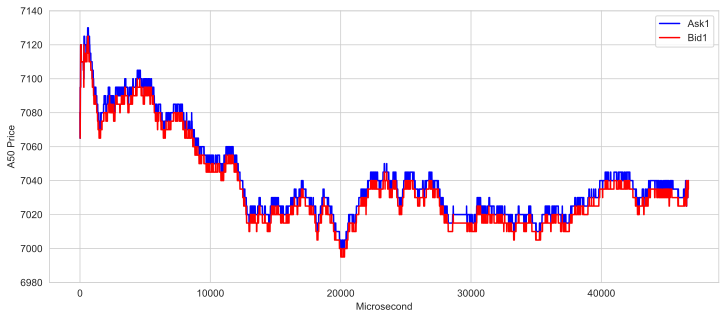

In [17]:
# 所有时间段
sns.set_style("whitegrid")
plt.figure(figsize = (12,5))
plt.plot(ask_price_1[2:len(ask_price_1)],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[2:len(ask_price_1)],label = 'Bid1',color = 'r')
plt.ylim(6980,7140)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.savefig("./images/bid1ask1.png", dpi=800)
plt.show()

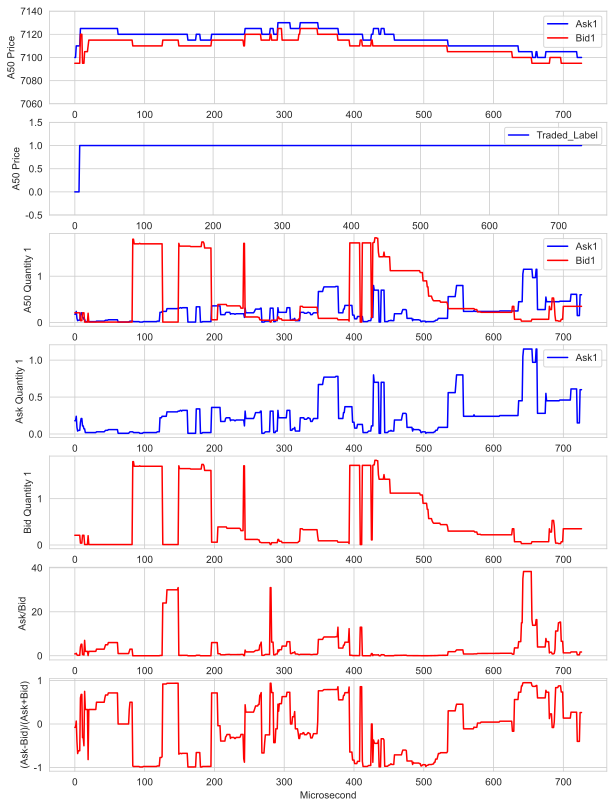

In [23]:
# 开盘前时间段
# Open ~ 09:15

# 对bid，ask，bidqty，askqty，level-1的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")
time1 = 294
time2 = 1021
plt.figure(figsize = (10,14))
plt.subplot(711)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7060,7140)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(712)
plt.plot(traded_micsecond_1,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Second")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(713)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("A50 Quantity 1")
plt.legend(loc = 1)
plt.subplot(714)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
# plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Ask Quantity 1")
plt.legend(loc = 1)
plt.subplot(715)
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Bid Quantity 1")
plt.subplot(716)
plt.plot(ask_quantity_1[time1:time2]/bid_quantity_1[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Depth")
plt.subplot(717)
plt.plot((ask_quantity_1[time1:time2]-bid_quantity_1[time1:time2])/\
     (ask_quantity_1[time1:time2]+bid_quantity_1[time1:time2]),label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("OBI")

plt.savefig("./images/depth_0000_0915.png", dpi=800)
plt.show()

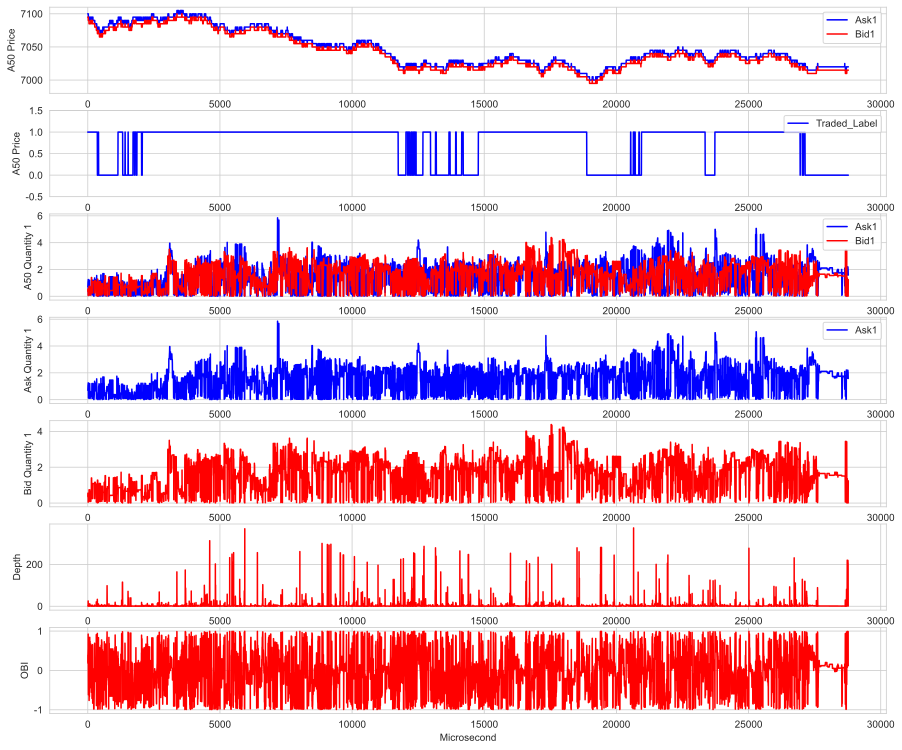

In [29]:
# 上午交易时段
# 09:15 ~ 11:30

# 对bid，ask，bidqty，askqty，level-1的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time1 = 1023
time2 = 29798
plt.figure(figsize = (15,13))
plt.subplot(711)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(6980,7110)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(712)
plt.plot(traded_micsecond_2,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(713)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,500)
plt.xlabel("Microsecond")
plt.ylabel("A50 Quantity 1")
plt.legend(loc = 1)

plt.subplot(714)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
# plt.ylim(0,500)
plt.xlabel("Microsecond")
plt.ylabel("Ask Quantity 1")
plt.legend(loc = 1)

plt.subplot(715)
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,500)
plt.xlabel("Microsecond")
plt.ylabel("Bid Quantity 1")

plt.subplot(716)
plt.plot(ask_quantity_1[time1:time2]/bid_quantity_1[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Depth")

plt.subplot(717)
plt.plot((ask_quantity_1[time1:time2]-bid_quantity_1[time1:time2])/\
     (ask_quantity_1[time1:time2]+bid_quantity_1[time1:time2]),label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("OBI")

plt.savefig("./images/depth_0915_1130.png", dpi=800)
plt.show()

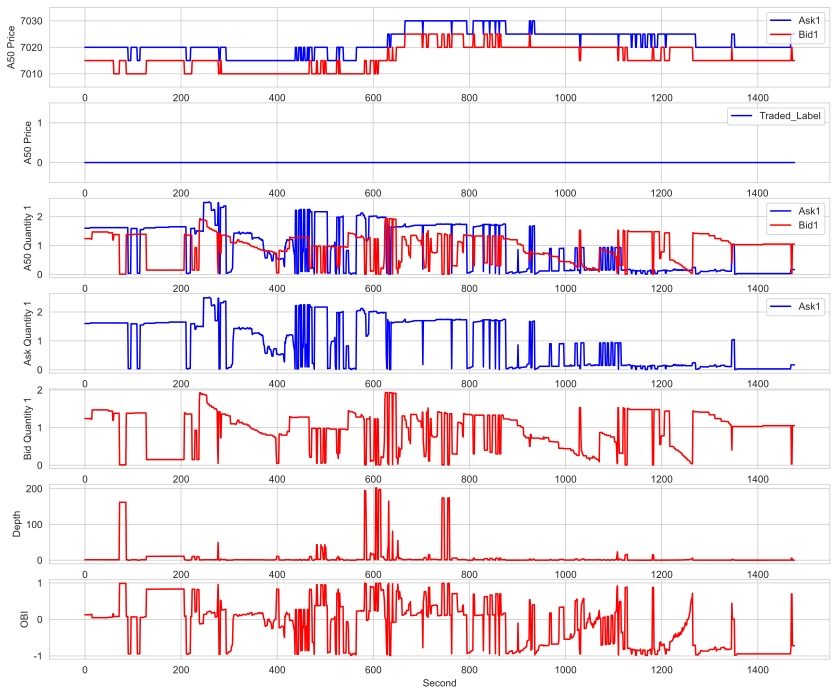

In [31]:
# 中午收盘时间：price不变，但ask和bid还在变化
# Open 11:30 ~ 13:00 => china close

# 对bid，ask，bidqty，askqty，level-1的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time1 = 29799
time2 = 31276
plt.figure(figsize = (14, 12))

plt.subplot(711)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7005,7035)
plt.xlabel("Micsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(712)
plt.plot(traded_micsecond_3,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(713)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,500)
plt.xlabel("Second")
plt.ylabel("A50 Quantity 1")
plt.legend(loc = 1)

plt.subplot(714)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
# plt.ylim(0,500)
plt.xlabel("Second")
plt.ylabel("Ask Quantity 1")
plt.legend(loc = 1)

plt.subplot(715)
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,500)
plt.xlabel("Second")
plt.ylabel("Bid Quantity 1")

plt.subplot(716)
plt.plot(ask_quantity_1[time1:time2]/bid_quantity_1[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Second")
plt.ylabel("Depth")
plt.subplot(717)
plt.plot((ask_quantity_1[time1:time2]-bid_quantity_1[time1:time2])/\
     (ask_quantity_1[time1:time2]+bid_quantity_1[time1:time2]),label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Second")
plt.ylabel("OBI")

plt.savefig("./images/depth_1130_1300.png", dpi=800)
plt.show()

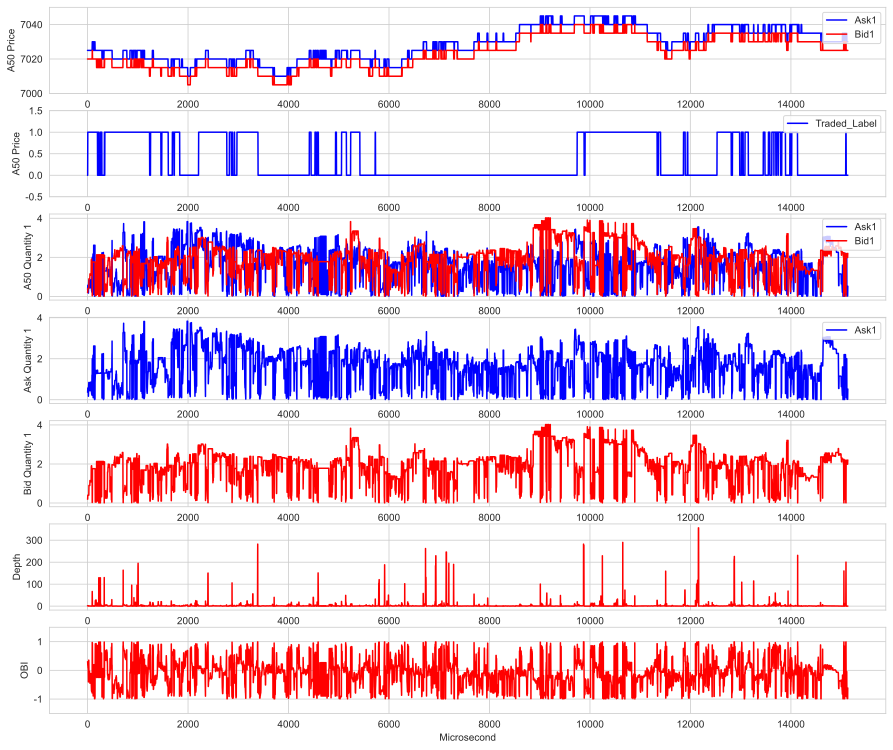

In [33]:
# 下午开盘时间
# Open 13:00 ~ 16:00

# 对bid，ask，bidqty，askqty，level-1的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time1 = 31279
time2 = 46412
plt.figure(figsize = (15,13))
plt.subplot(711)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7000,7050)
plt.xlabel("Second")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(712)
plt.plot(traded_micsecond_4,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(713)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,500)
plt.xlabel("Microsecond")
plt.ylabel("A50 Quantity 1")
plt.legend(loc = 1)

plt.subplot(714)
plt.plot(ask_quantity_1[time1:time2],label = 'Ask1',color = 'b')
# plt.ylim(0,500)
plt.xlabel("Microsecond")
plt.ylabel("Ask Quantity 1")
plt.legend(loc = 1)

plt.subplot(715)
plt.plot(bid_quantity_1[time1:time2],label = 'Bid1',color = 'r')
# plt.ylim(0,500)
plt.xlabel("Microsecond")
plt.ylabel("Bid Quantity 1")

plt.subplot(716)
plt.plot(ask_quantity_1[time1:time2]/bid_quantity_1[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Depth")

plt.subplot(717)
plt.plot((ask_quantity_1[time1:time2]-bid_quantity_1[time1:time2])/\
     (ask_quantity_1[time1:time2]+bid_quantity_1[time1:time2]),label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
plt.ylim(-1.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("OBI")

plt.savefig("./images/depth_1300_1600.png", dpi=800)
plt.show()

- 以上过程可以对bid2, ask2以及bid3, ask3重新计算所有的信号指标，计算相应的Depth Ratio和OBI

- 需要注意的是，上面的Depth Ratio和OBI均为未加权的、level-1的信号指标（只用了一层的bid和ask），以下设计我们需要使用的**weighted depth ratio**和**weighted multi-level OBI**

#### **Weighted Depth Ratio, OBI**

**不同时间段价格、数量、加权多级订单簿数据的Depth Ratio、OBI可视化**

In [34]:
# 尝试一组权重
Weight_Ask = (50.0 * ask_quantity_1 + 30.0 * ask_quantity_2 + 20.0 * ask_quantity_3)
Weight_Bid = (50.0 * bid_quantity_1 + 30.0 * bid_quantity_2 + 20.0 * bid_quantity_3)

# Weighted Depth Ratio
W_AB = Weight_Ask/Weight_Bid

# Weighted level-3 OBI
W_A_B = (Weight_Ask - Weight_Bid)/(Weight_Ask + Weight_Bid)

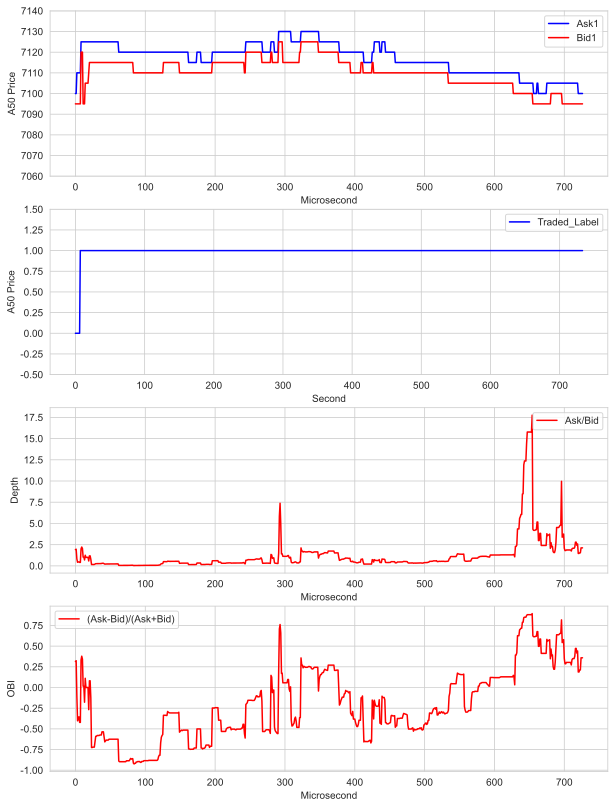

In [42]:
# 开盘前
# Open 0 ~ 09:15

# 对bid，ask，bidqty，askqty，加权多级行情的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")
time1 = 294
time2 = 1021
plt.figure(figsize = (10,14))
plt.subplot(411)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7060,7140)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(412)
plt.plot(traded_micsecond_1,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Second")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(413)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Depth")
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("OBI")
plt.legend(loc = 'best')

plt.savefig("./images/depth_0000_0900_w.png", dpi=800)
plt.show()

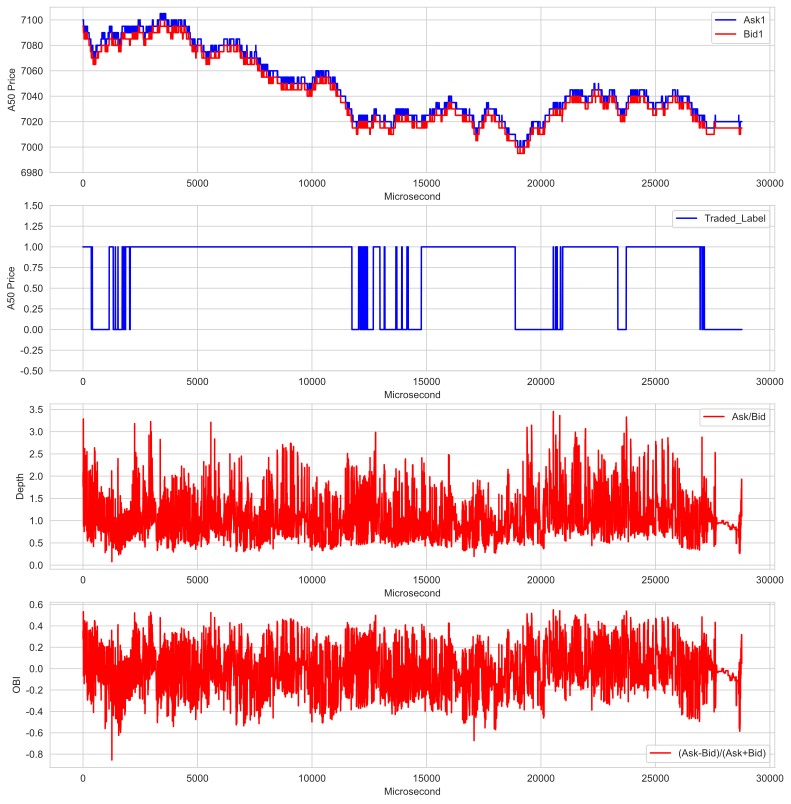

In [45]:
# Open 09:15 ~ 11:30

# 对bid，ask，bidqty，askqty，加权多级行情的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time1 = 1023
time2 = 29798
plt.figure(figsize = (13,14))
plt.subplot(411)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(6980,7110)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(412)
plt.plot(traded_micsecond_2,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(413)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Depth")
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)', color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("OBI")
plt.legend(loc = 'best')

plt.savefig("./images/depth_0900_1130_w.png", dpi=800)
plt.show()

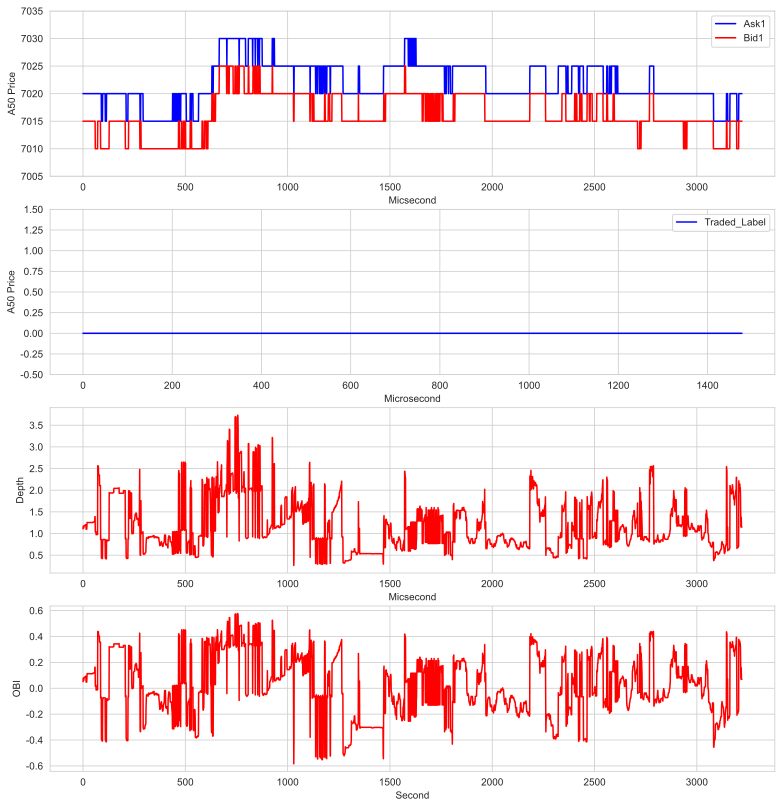

In [47]:
# Open 11:30 ~ 13:00 => china close

# 对bid，ask，bidqty，askqty，加权多级行情的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time1 = 29799
time2 = 33020
plt.figure(figsize = (13,14))
plt.subplot(411)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7005,7035)
plt.xlabel("Micsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(412)
plt.plot(traded_micsecond_3,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(413)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
plt.xlabel("Micsecond")
plt.ylabel("Depth")

plt.subplot(414)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
plt.xlabel("Second")
plt.ylabel("OBI")

plt.savefig("./images/depth_1130_1300_w.png", dpi=800)
plt.show()

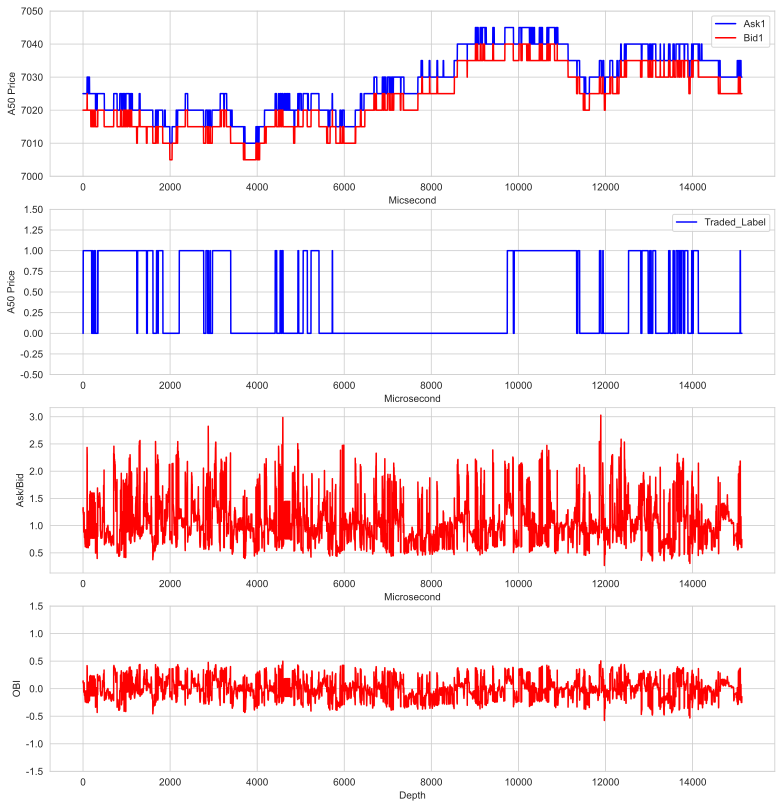

In [48]:
# Open 13:00 ~ 16:00

# 对bid，ask，bidqty，askqty，加权多级行情的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time1 = 31279
time2 = 46412
plt.figure(figsize = (13,14))
plt.subplot(411)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7000,7050)
plt.xlabel("Micsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(412)
plt.plot(traded_micsecond_4,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(413)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
plt.xlabel("Microsecond")
plt.ylabel("Ask/Bid")

plt.subplot(414)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
plt.ylim(-1.5,1.5)
plt.xlabel("Depth")
plt.ylabel("OBI")

plt.savefig("./images/depth_1300_1600_w.png", dpi=800)
plt.show()

### **Rise Ratio + Depth Ratio + OBI**

- Rise Ratio定义为ask1的斜率时间序列（也可以尝试改成buy1价格的斜率时序）。斜率在这里就相当于一个future lagged return。
- 其中的参数是`before_time`，可以理解成一个时间节点。在此时间节点前，rise ratio定义为当下ask1的价格相对于初始ask1(初始ask1是9:00的数据而不是最早的数据)的涨跌幅；
- 而在时间节点后，rise ratio定义为一个moving return，也就是始终取过去`before_time`段的moving return，容易理解（因为一开始间隔没有到before_time，因此取的是起点，后来间隔有了就是一个滑动的卖一收益率）

In [ ]:
# Ask1为9:00后的卖一价序列，timestamp_time_second是经过处理后的时间格式，before_time为一个需要调的参数
def rise_ask(Ask1, timestamp_time_second, before_time):
    Ask1[Ask1 == 0] = np.mean(Ask1) #填充卖一为0的地方为均值
    rise_ratio = []
    index = np.where(timestamp_time_second >= before_time)[0][0]    
    # open first before_time mins
    for i in range(0,index,1):
        rise_ratio_ = round((Ask1[i] - Ask1[0])*(1.0)/Ask1[0]*100,5)
        rise_ratio.append(rise_ratio_)
    for i in range(index,len(Ask1),1):
        index_start = np.where(timestamp_time_second[:i] >= timestamp_time_second[i] - before_time)[0][0]
        rise_ratio_ = round((Ask1[i] - Ask1[index_start])*(1.0)/Ask1[index_start]*100,5)
        rise_ratio.append(rise_ratio_)
    return rise_ratio

# Rise Ratio
# before_time = 60.0 * 5 # 300 seconds
# index = np.where(time_second_basic <= 0.0)[0][-1]   
# Ask1 = ask_price_1[np.where(time_second_basic <= 0.0)[0][-1]:]
# rise_ratio_ask = rise_ask(Ask1,time_second_basic,before_time)

In [ ]:
def weight_pecentage(w1,w2,w3):
    Weight_Ask = (w1 * ask_quantity_1 + w2 * ask_quantity_2 + w3 * ask_quantity_3)
    Weight_Bid = (w1 * bid_quantity_1 + w2 * bid_quantity_2 + w3 * bid_quantity_3)
    W_AB = Weight_Ask/Weight_Bid
    W_A_B = (Weight_Ask - Weight_Bid)/(Weight_Ask + Weight_Bid)
    return W_AB,W_A_B

In [50]:
# 我们进一步严谨地定义我们的label，之前定义的label其实有一些datetime上的特殊情况无法处理，这里使用条件句把所有情况都考虑在内了
# 多一个参数记为traded_time，单位为秒，这就是一个hyperparameter，也就是当前的bid price高于之后多长时间内ask price的最小值决定买入(label=1)
# 之前这个参数默认为15min了(即traded_time=300)，现在写成一个参数可以自行修改
def traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1, traded_time):
    traded = []
    index_ = []
    if time1 == 0:
        index_one = np.where(time_second_basic <= 0)[0][-1]
    elif time1 == 14400:
        index_one = np.where(time_second_basic <= 14400)[0][-1]
        
    for i in range(time1, time2, 1):
        if i == 0 or i == 14400:
            index_array = np.where(time_second_basic <= i)[-1]
        else:
            index_array = np.where((time_second_basic < i+1) & (time_second_basic >= i))[-1]
        
        if len(index_array) > 0:
            index = index_array[-1]
            if i == time1:
                index_.append(index)
            if i == time2 - 1:
                index_.append(index)
            if i < 25200 - traded_time:
                index_min = np.where(time_second_basic <= i + traded_time)[0][-1]
                traded_min = ask_price_1[index:index_min]
                if bid_price_1[index] > min(traded_min):
                    traded.append(1)
                else:
                    traded.append(0)
            elif i >= 25200 - traded_time:
                if bid_price_1[index] > ask_price_1[-1]:
                    traded.append(1)
                else:
                    traded.append(0)
    return traded

In [58]:
# 同样对每个tick的label情况进行更改，添加traded_time参数
def traded_label_micsecond(time1,time2,time_second_basic,bid_price_1,ask_price_1,traded_time):
    traded = []
    index_ = []
    micsecond = time_second_basic[np.where((time_second_basic >= time1) & (time_second_basic <= time2))]
    for i in range(0,len(micsecond),1):
        
        index = np.where(time_second_basic <= micsecond[i])[0][-1]
        if i == 0:
            index_.append(index)
        if i == len(micsecond) - 1:
            index_.append(index)
        if micsecond[i] <= 25200 - traded_time:
            index_min = np.where(time_second_basic <= micsecond[i] + traded_time)[0][-1]
            if bid_price_1[index] > min(ask_price_1[index:index_min]):
                traded.append(1)
            else:
                traded.append(0)
        elif micsecond[i] > 25200 - traded_time:
            if bid_price_1[index] > ask_price_1[-1]:
                traded.append(1)
            else:
                traded.append(0)
        # print(index, index_min)
    return traded, index_

In [62]:
# 得到不同时间段的训练标签并打印对应区间内有多少次label为1，多少次为0

# 我们还是默认取15min的data
traded_time = 300

# 09:00 ~ 09:15
time1 = 0
time2 = 900
traded_1 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_1) == 0)[0]),len(np.where(np.array(traded_1) == 1)[0]))

# 09:15 ~ 11:30
time1 = 900+1
time2 = 9000
traded_2 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_2) == 0)[0]),len(np.where(np.array(traded_2) == 1)[0]))

# 11:30 ~ 1:00
time1 = 9000+1
time2 = 14400
traded_3 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_3) == 0)[0]),len(np.where(np.array(traded_3) == 1)[0]))

# 01:00 ~ 16:00
time1 = 14400+1
time2 = 25200
traded_4 = traded_label_one_second(time1,time2,time_second_basic,bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_4) == 0)[0]),len(np.where(np.array(traded_4) == 1)[0]))

173 132
3162 3129
620 0
4489 660


In [61]:
# 我们还是默认取15min的data
traded_time = 300
# 09:00 ~ 09:15
time1 = 0
time2 = 900
traded_micsecond_1,index_1 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_micsecond_1) == 0)[0]),len(np.where(np.array(traded_micsecond_1) == 1)[0]))
            
# 09:15 ~ 11:30
time1 = 900+1
time2 = 9000
traded_micsecond_2,index_2 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_micsecond_2) == 0)[0]),len(np.where(np.array(traded_micsecond_2) == 1)[0]))
            
# 11:30 ~ 1:00
time1 = 9000+1
time2 = 14400
traded_micsecond_3,index_3 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_micsecond_3) == 0)[0]),len(np.where(np.array(traded_micsecond_3) == 1)[0]))
            
# 01:00 ~ 16:00
time1 = 14400+1
time2 = 25200
traded_micsecond_4,index_4 = traded_label_micsecond(time1,time2,time_second_basic,\
                                                    bid_price_1,ask_price_1,traded_time)
print(len(np.where(np.array(traded_micsecond_4) == 0)[0]),len(np.where(np.array(traded_micsecond_4) == 1)[0]))

380 354
15398 13379
1478 0
13606 1800


In [63]:
index_1, index_2, index_3, index_4

([291, 1018], [1020, 29795], [29796, 31273], [31276, 46679])

In [64]:
import time 
start = time.time()

# 任意取一组参数计算rise ratio和weight depth进行可视化

# Rise Ratio
before_time = 60.0 * 5 # second
index = np.where(time_second_basic <= 0.0)[0][-1]   
Ask1 = ask_price_1[np.where(time_second_basic <= 0.0)[0][-1]:]
rise_ratio_ask = rise_ask(Ask1,time_second_basic,before_time)

# Weight Depth
w1,w2,w3 = [50.0,30.0,20.0]
W_AB,W_A_B = weight_pecentage(w1,w2,w3)

end = time.time()  
print("Total time = %f"%(end - start))

Total time = 0.797760


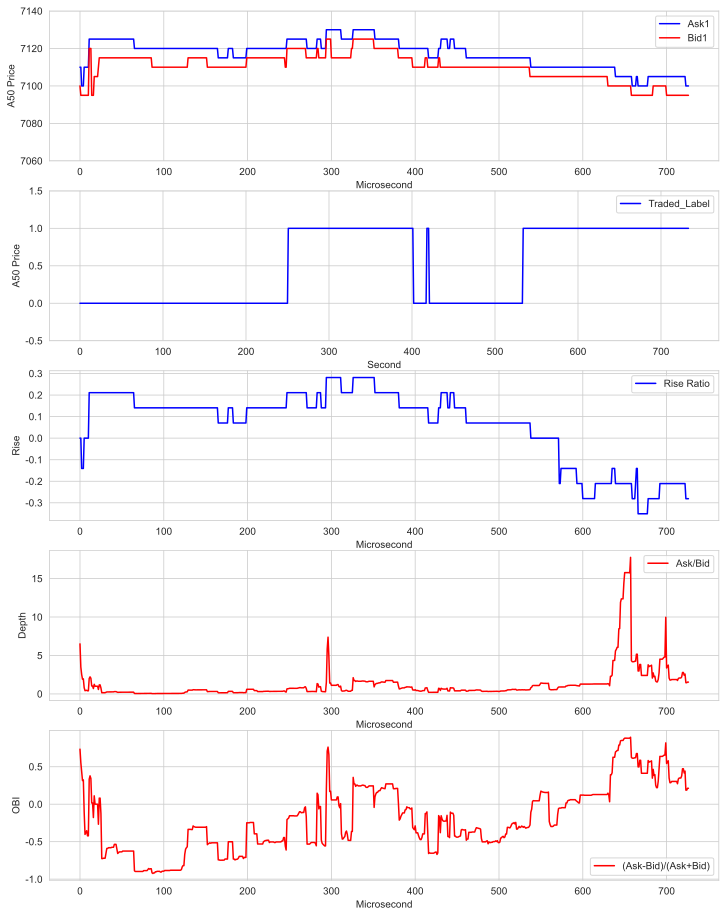

In [68]:
# Open 0 ~ 09:15

# 对bid，ask，bidqty，askqty，rise ratio，加权多级行情的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time1 ,time2 = index_1
plt.figure(figsize = (12,16))
plt.subplot(511)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7060,7140)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

# 画出tick下的target label，即一个0,1序列。也可以更改为每秒的target label
plt.subplot(512)
plt.plot(traded_micsecond_1,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Second")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.plot(rise_ratio_ask[0:(time2-time1)],label = 'Rise Ratio',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise")
plt.legend(loc = "best")

plt.subplot(514)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Depth")
plt.legend(loc = "best")


plt.subplot(515)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("OBI")
plt.legend(loc = "best")

plt.savefig("./images/rise_0000_0915_w.png", dpi=800)
plt.show()

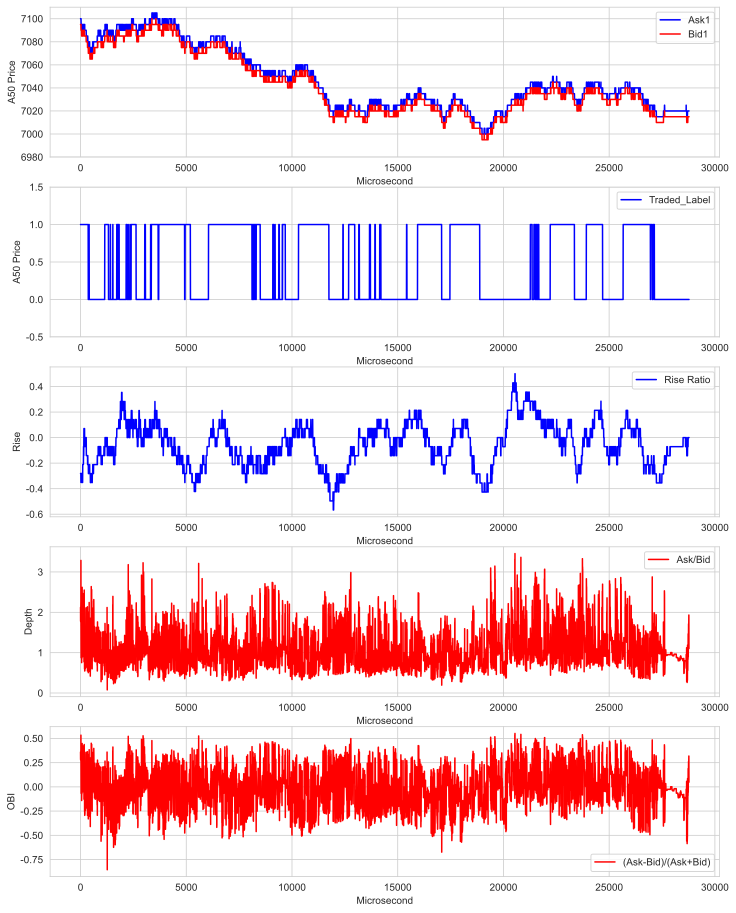

In [70]:
# Open 09:15 ~ 11:30

sns.set_style("whitegrid")

time01 ,time02 = index_1
time1 ,time2 = index_2

plt.figure(figsize = (12,16))


plt.subplot(511)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(6980,7110)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(512)
plt.plot(traded_micsecond_2,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.plot(rise_ratio_ask[time02-time01:][0:(time2-time1)],label = 'Rise Ratio',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise")
plt.legend(loc = "best")

plt.subplot(514)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("Depth")
plt.legend(loc = "best")


plt.subplot(515)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
#plt.ylim(0,400)
plt.xlabel("Microsecond")
plt.ylabel("OBI")
plt.legend(loc = "best")


plt.savefig("./images/rise_0915_1130_w.png", dpi=800)
plt.show()

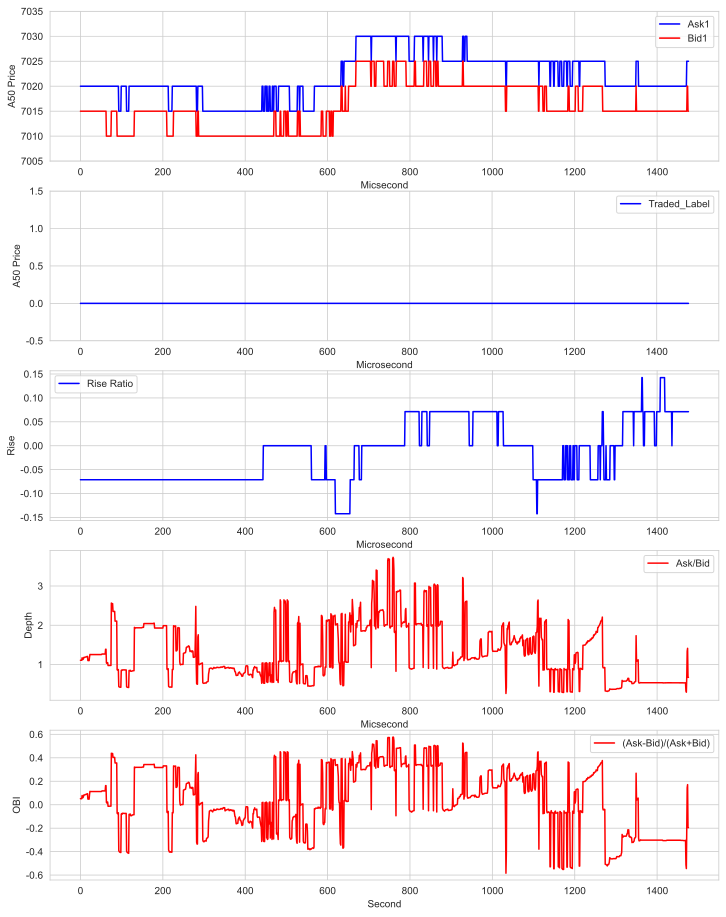

In [72]:
# Open 11:30 ~ 13:00 => china close

# 对bid，ask，bidqty，askqty，rise ratio，加权多级行情的depth ratio和OBI因子进行可视化

sns.set_style("whitegrid")

time01 ,time02 = index_2
time1 ,time2 = index_3

plt.figure(figsize = (12,16))
plt.subplot(511)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7005,7035)
plt.xlabel("Micsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(512)
plt.plot(traded_micsecond_3,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.plot(rise_ratio_ask[time02-time01:][0:(time2-time1)],label = 'Rise Ratio',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise")
plt.legend(loc = "best")


plt.subplot(514)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
plt.xlabel("Micsecond")
plt.ylabel("Depth")
plt.legend(loc = "best")

plt.subplot(515)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
plt.xlabel("Second")
plt.ylabel("OBI")
plt.legend(loc = "best")

plt.savefig("./images/rise_1130_1300_w.png", dpi=800)
plt.show()

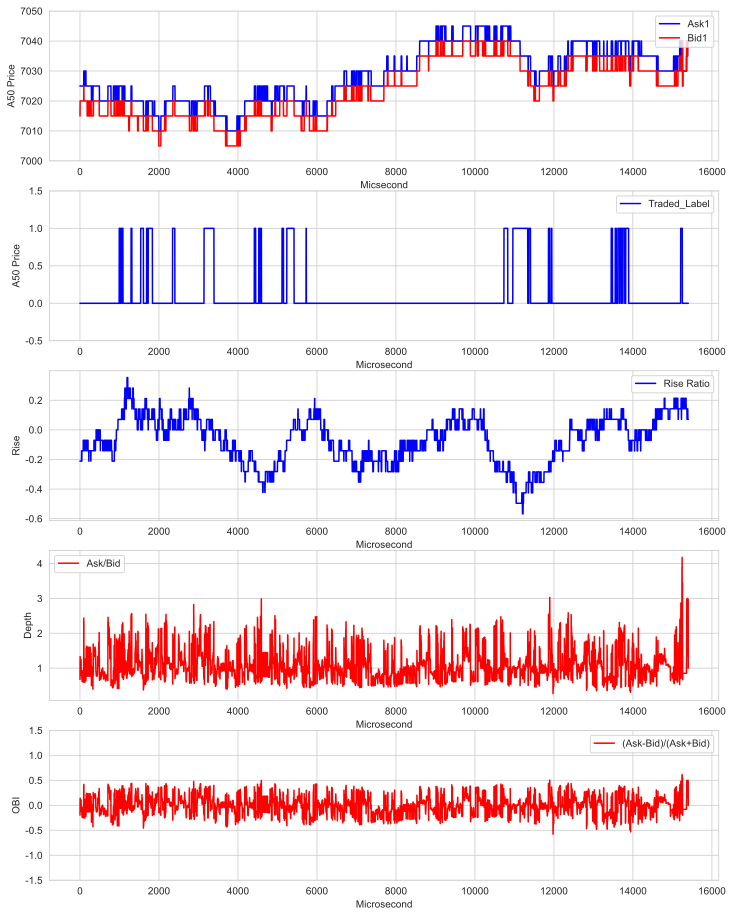

In [74]:
# Open 13:00 ~ 16:00

sns.set_style("whitegrid")

time01 ,time02 = index_3
time1,time2 = index_4
plt.figure(figsize = (12,16))
plt.subplot(511)
plt.plot(ask_price_1[time1:time2],label = 'Ask1',color = 'b')
plt.plot(bid_price_1[time1:time2],label = 'Bid1',color = 'r')
plt.ylim(7000,7050)
plt.xlabel("Micsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(512)
plt.plot(traded_micsecond_4,label = 'Traded_Label',color = 'b')
plt.ylim(-0.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("A50 Price")
plt.legend(loc = 1)

plt.subplot(513)
plt.plot(rise_ratio_ask[time02-time01:][0:(time2-time1)],label = 'Rise Ratio',color = 'b')
plt.xlabel("Microsecond")
plt.ylabel("Rise")
plt.legend(loc = "best")


plt.subplot(514)
plt.plot(W_AB[time1:time2],label = 'Ask/Bid',color = 'r')
plt.xlabel("Microsecond")
plt.ylabel("Depth")
plt.legend(loc = "best")


plt.subplot(515)
plt.plot(W_A_B[time1:time2],label = '(Ask-Bid)/(Ask+Bid)',color = 'r')
plt.ylim(-1.5,1.5)
plt.xlabel("Microsecond")
plt.ylabel("OBI")
plt.legend(loc = "best")

plt.savefig("./images/rise_1300_1600_w.png", dpi=800)
plt.show()
